In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
%matplotlib inline

## Charles Dickens
### Bleak House

In [2]:
BODY_START = 214
BODY_END = 39872
CHAP_PAT = r'^\s*(?:CHAPTER).*$'
PARA_PAT = r'\n\n+'
SENT_PAT = r'([.;?!"“”]+)'
TOKEN_PAT = r'([\W_]+)'
src_file = 'data/Bleak_House.txt'

In [3]:
lines = open(src_file, 'r', encoding='utf-8').readlines()

In [4]:
lines = lines[BODY_START - 1 : BODY_END + 1]

In [5]:
lines[:10]

['CHAPTER I\n',
 '\n',
 'In Chancery\n',
 '\n',
 '\n',
 'London. Michaelmas term lately over, and the Lord Chancellor sitting\n',
 "in Lincoln's Inn Hall. Implacable November weather. As much mud in\n",
 'the streets as if the waters had but newly retired from the face of\n',
 'the earth, and it would not be wonderful to meet a Megalosaurus,\n',
 'forty feet long or so, waddling like an elephantine lizard up Holborn\n']

In [6]:
df = pd.DataFrame({'line_str':lines})
df.index.name = 'line_id'

In [7]:
df.head()

,line_str
line_id,
0,CHAPTER I\n
1,\n
2,In Chancery\n
3,\n
4,\n


In [8]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('tagsets')
# nltk.download('wordnet')

In [9]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

In [10]:
def text_to_tokens(
                   src_file,
                   body_start=0, 
                   body_end=-1, 
                   chap_pat=r'^\s*Chapter.*$', 
                   para_pat=r'\n\n+', 
                   sent_pat=r'([.;?!"“”]+)', 
                   token_pat=r'([\W_]+)'):

    # Text to lines
    lines = open(src_file, 'r', encoding='utf-8').readlines()
    lines = lines[body_start - 1 : body_end + 1]
    df = pd.DataFrame({'line_str':lines})
    df.index.name = 'line_id'
    del(lines)
    
    # FIX CHARACTERS TO IMPROVE TOKENIZATION
    df.line_str = df.line_str.str.replace('—', ' — ')
    df.line_str = df.line_str.str.replace('-', ' - ')

    # Lines to Chapters
    mask = df.line_str.str.match(chap_pat)
    df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
    df.chap_id = df.chap_id.ffill().astype('int')
    chap_ids = df.chap_id.unique().tolist()
    df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
    chaps = df.groupby('chap_num')\
        .apply(lambda x: ''.join(x.line_str))\
        .to_frame()\
        .rename(columns={0:'chap_str'})
    del(df)

    # Chapters to Paragraphs
    paras = chaps.chap_str.str.split(para_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'para_str'})
    paras.index.names = PARAS
    paras.para_str = paras.para_str.str.strip()
    paras.para_str = paras.para_str.str.replace(r'\n', ' ')
    paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
    paras = paras[~paras.para_str.str.match(r'^\s*$')]
    del(chaps)

    # Paragraphs to Sentences
#     sents = paras.para_str.str.split(sent_pat, expand=True)\
    sents = paras.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    sents.index.names = SENTS
    del(paras)

    # Sentences to Tokens
#     tokens = sents.sent_str.str.split(token_pat, expand=True)\
    tokens = sents.sent_str\
        .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    tokens.index.names = OHCO
    del(sents)
    
    tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
    tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
    tokens = tokens.drop('pos_tuple', 1)

    # Tag punctuation and numbers
    tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
    tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
    
    # Extract vocab with minimal normalization
    WORDS = (tokens.punc == 0) & (tokens.num == 0)
    tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
        .str.replace(r'["_*.]', '')
    
    vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
        .reset_index()\
        .rename(columns={'index':'term_str', 'term_str':'n'})
    vocab = vocab.sort_values('term_str').reset_index(drop=True)
    vocab.index.name = 'term_id'
    
    # Get priors for V
    vocab['p'] = vocab.n / vocab.n.sum()
    
    # Add stems
    stemmer = nltk.stem.porter.PorterStemmer()
    vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))
    
    # Define stopwords
    sw = pd.DataFrame({'x':1}, index=nltk.corpus.stopwords.words('english'))
    vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
    del(sw)
            
    # Add term_ids to tokens 
    tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
        .set_index('term_str').term_id).fillna(-1).astype('int')

    return tokens, vocab

def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [11]:
cfg = dict(
    src_file = src_file,
    body_start = 214,
    body_end = 39872,
    chap_pat = r'^\s*(?:CHAPTER).*$'
)
BH_K, BH_V = text_to_tokens(**cfg)

In [12]:
BH_K.head()

pos token_str  punc  num  term_str  \
chap_num para_num sent_num token_num                                       
0        0        0        0           NN   CHAPTER     0    0   chapter   
                           1          PRP         I     0    0         i   
         1        0        0           IN        In     0    0        in   
                           1          NNP  Chancery     0    0  chancery   
         2        0        0          NNP    London     0    0    london   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             2100  
                           1             6615  
         1        0        0             6781  
                           1             2084  
         2        0        0             7822

In [13]:
BH_K = BH_K.loc[BH_K.term_id >= 0]

In [14]:
BH_K.head()

pos token_str  punc  num  term_str  \
chap_num para_num sent_num token_num                                       
0        0        0        0           NN   CHAPTER     0    0   chapter   
                           1          PRP         I     0    0         i   
         1        0        0           IN        In     0    0        in   
                           1          NNP  Chancery     0    0  chancery   
         2        0        0          NNP    London     0    0    london   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             2100  
                           1             6615  
         1        0        0             6781  
                           1             2084  
         2        0        0             7822

In [15]:
BH_V.head()

,term_str,n,p,port_stem,stop
term_id,,,,,
0,'ackney,1,0.000003,'ackney,0
1,'ah,1,0.000003,'ah,0
2,'and,3,0.000008,'and,0
3,'are,1,0.000003,'are,0
4,'as,1,0.000003,'a,0


In [16]:
WORDS = (BH_K.punc == 0) & (BH_K.num == 0) & BH_K.term_id.isin(BH_V[BH_V.stop==0].index)

In [17]:
BOW = BH_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [18]:
DTM = BOW.unstack().fillna(0)

In [19]:
DTM.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,14993,14994,14995,14996,14997,14998,14999,15000,15001,15002
chap_num,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
alpha = .000001
alpha_sum = alpha * BH_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [21]:
N_docs = DTM.shape[0]
BH_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / BH_V[BH_V.stop==0]['df'])

In [22]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,14993,14994,14995,14996,14997,14998,14999,15000,15001,15002
chap_num,,,,,,,,,,,,,,,,,,,,,
0,4.424524e-09,4.424524e-09,3.268474e-09,4.424524e-09,4.424524e-09,4.424524e-09,4.424524e-09,4.424524e-09,4.424524e-09,4.424524e-09,...,4.424524e-09,4.424524e-09,4.424524e-09,4.424524e-09,2.539087e-09,4.424524e-09,4.424524e-09,4.424524e-09,3.695138e-09,4.424524e-09
1,4.215445e-09,4.215445e-09,3.114024e-09,4.215445e-09,4.215445e-09,4.215445e-09,4.215445e-09,4.215445e-09,4.215445e-09,4.215445e-09,...,4.215445e-09,4.215445e-09,4.215445e-09,4.215445e-09,2.419104e-09,4.215445e-09,4.215445e-09,4.215445e-09,3.520526e-09,4.215445e-09
2,1.657848e-09,1.657848e-09,1.224681e-09,1.657848e-09,1.657848e-09,1.657848e-09,1.657848e-09,1.657848e-09,1.657848e-09,1.657848e-09,...,1.657848e-09,1.657848e-09,1.657848e-09,1.657848e-09,9.513836e-10,1.657848e-09,1.657848e-09,1.657848e-09,1.384550e-09,1.657848e-09
3,2.533856e-09,2.533856e-09,1.871806e-03,2.533856e-09,2.533856e-09,2.533856e-09,2.533856e-09,2.533856e-09,2.533856e-09,2.533856e-09,...,2.533856e-09,2.533856e-09,2.533856e-09,2.533856e-09,1.454096e-09,2.533856e-09,2.533856e-09,2.533856e-09,2.116148e-09,2.533856e-09
4,2.153375e-09,2.153375e-09,1.590736e-09,2.153375e-09,2.153375e-09,2.153375e-09,2.153375e-09,2.153375e-09,2.153375e-09,2.153375e-09,...,2.153375e-09,2.153375e-09,2.153375e-09,2.153375e-09,1.235750e-09,2.153375e-09,2.153375e-09,2.153375e-09,1.798389e-09,2.153375e-09


In [23]:
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1)

In [24]:
TFTH.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,14993,14994,14995,14996,14997,14998,14999,15000,15001,15002
chap_num,,,,,,,,,,,,,,,,,,,,,
0,2.847204e-12,2.890899e-12,1.015501e-11,2.948698e-12,2.487204e-12,3.369212e-12,3.511555e-12,5.409014e-12,2.057747e-12,4.643965e-12,...,2.896133e-12,5.862688e-12,6.492928e-12,3.246379e-12,1.642493e-11,2.776611e-12,4.195269e-12,5.862688e-12,5.555765e-12,4.563125e-12
1,2.712661e-12,2.754291e-12,9.675144e-12,2.809359e-12,2.369672e-12,3.210002e-12,3.345618e-12,5.153413e-12,1.960509e-12,4.424517e-12,...,2.759278e-12,5.585650e-12,6.186108e-12,3.092973e-12,1.564878e-11,2.645404e-12,3.997024e-12,5.585650e-12,5.293230e-12,4.347496e-12
2,1.066833e-12,1.083206e-12,3.805034e-12,1.104863e-12,9.319431e-13,1.262427e-12,1.315762e-12,2.026731e-12,7.710278e-13,1.740071e-12,...,1.085167e-12,2.196721e-12,2.432868e-12,1.216402e-12,6.154341e-12,1.040383e-12,1.571947e-12,2.196721e-12,2.081718e-12,1.709781e-12
3,1.630549e-12,1.655573e-12,5.815624e-06,1.688674e-12,1.424383e-12,1.929495e-12,2.011013e-12,3.097658e-12,1.178440e-12,2.659526e-12,...,1.658570e-12,3.357470e-12,3.718399e-12,1.859151e-12,9.406301e-12,1.590122e-12,2.402565e-12,3.357470e-12,3.181700e-12,2.613230e-12
4,1.385708e-12,1.406974e-12,4.942351e-12,1.435104e-12,1.210499e-12,1.639764e-12,1.709041e-12,2.632517e-12,1.001486e-12,2.260175e-12,...,1.409521e-12,2.853316e-12,3.160048e-12,1.579982e-12,7.993861e-12,1.351351e-12,2.041799e-12,2.853316e-12,2.703939e-12,2.220830e-12


In [25]:
BH_V['tf_sum'] = TF.sum()
BH_V['tf_mean'] = TF.mean()
BH_V['tf_max'] = TF.max()
BH_V['tfidf_sum'] = TFIDF.sum()
BH_V['tfidf_mean'] = TFIDF.mean()
BH_V['tfidf_max'] = TFIDF.max()
BH_V['tfth_sum'] = TFTH.sum()
BH_V['tfth_mean'] = TFTH.mean()
BH_V['tfth_max'] = TFTH.max()
BH_V['th_sum'] = THM.sum()
BH_V['th_mean'] = THM.mean()
BH_V['th_max'] = THM.max()

In [26]:
TOPS = pd.DataFrame(index=range(15))
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = BH_V.sort_values(key, ascending=False).term_str.head(15).tolist()

In [27]:
TOPS

,tf_mean,tf_max,tfidf_mean,tfidf_max,tfth_mean,tfth_max,th_mean,th_max
0,mr,mr,snagsby,bagnet,mr,mr,mr,mr
1,'s,bucket,george,ladyship,'s,'s,'s,bucket
2,said,snagsby,bagnet,jobling,said,said,said,snagsby
3,n't,ladyship,bucket,snagsby,n't,sir,n't,ladyship
4,little,charley,guppy,jo,little,n't,little,charley
5,sir,'s,leicester,chadband,sir,little,one,'s
6,one,guppy,caddy,bucket,one,lady,sir,guppy
7,would,said,jo,charley,would,says,would,said
8,know,jo,smallweed,phil,know,would,know,jo
9,says,bagnet,richard,fog,says,old,upon,bagnet


In [28]:
BH_V = BH_V[BH_V['stop'] == 0]

In [29]:
BH_V.head()

,term_str,n,p,port_stem,stop,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,,,,,,,
0,'ackney,1,0.000003,'ackney,0,1.0,0.000339,0.000005,0.000339,0.002054,0.000031,0.002054,1.321559e-06,1.972476e-08,1.321443e-06,0.003904,0.000058,0.003903
1,'ah,1,0.000003,'ah,0,1.0,0.000344,0.000005,0.000344,0.002090,0.000031,0.002090,1.365411e-06,2.037928e-08,1.365294e-06,0.003963,0.000059,0.003963
2,'and,3,0.000008,'and,0,3.0,0.001241,0.000019,0.000493,0.005560,0.000083,0.002211,1.727497e-05,2.578354e-07,6.868569e-06,0.013923,0.000208,0.005419
3,'are,1,0.000003,'are,0,1.0,0.000352,0.000005,0.000352,0.002138,0.000032,0.002137,1.424606e-06,2.126277e-08,1.424486e-06,0.004043,0.000060,0.004042
4,'as,1,0.000003,'a,0,1.0,0.000290,0.000004,0.000290,0.001760,0.000026,0.001760,9.893619e-07,1.476660e-08,9.892609e-07,0.003410,0.000051,0.003409


In [30]:
D = get_docs(BH_K, CHAPS, 'term_str', sep=" ")\
    .to_frame().rename(columns={'term_str':'doc_str'})

In [31]:
D['term_count'] = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [32]:
D.head()

,doc_str,term_count,tf
chap_num,,,
0,chapter i in chancery london michaelmas term l...,1371,0.008044
1,chapter ii in fashion it is but a glimpse of t...,1439,0.008442
2,chapter iii a progress i have a great deal of ...,3659,0.021467
3,chapter iv telescopic philanthropy we were to ...,2394,0.014045
4,chapter v a morning adventure although the mor...,2817,0.016527


### For each chapter, the proportion of the chapter in the whole book, defined as the number of words in the chapter over the the number of words in all chapters.

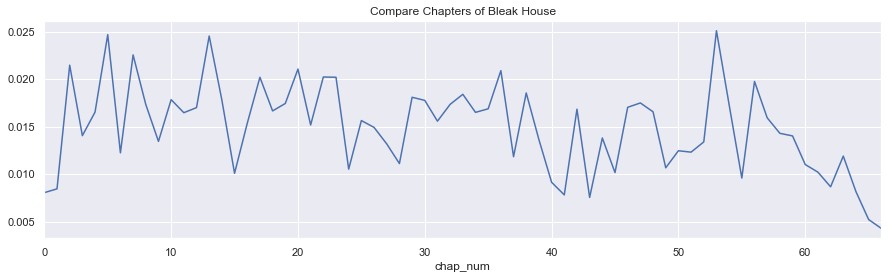

In [33]:
D.tf.plot(figsize=(15,4), title = 'Compare Chapters of Bleak House')

In [34]:
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]

In [35]:
BH_P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
BH_P.index.names = ['doc_x','doc_y']

In [36]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [37]:
BH_P['euclidean'] = 0
BH_P['euclidean'] = BH_P.apply(euclidean, 1)

In [38]:
BH_PME = BH_P.euclidean.unstack().fillna(0)

In [39]:
BH_PME.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,57,58,59,60,61,62,63,64,65,66
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.142201,0.126647,0.138853,0.127219,0.129142,0.143141,0.131303,0.130184,0.146612,0.139695,...,0.136444,0.131567,0.133715,0.136667,0.138775,0.152355,0.136383,0.136181,0.161932,0.148648
1,0.000000,0.099357,0.112314,0.099695,0.098799,0.109937,0.101563,0.099829,0.119289,0.110107,...,0.102233,0.100604,0.105160,0.107278,0.111965,0.125033,0.106616,0.108938,0.134080,0.122194
2,0.000000,0.000000,0.091476,0.076269,0.075801,0.098146,0.080774,0.077391,0.106517,0.094302,...,0.089018,0.079564,0.083496,0.086934,0.089559,0.111238,0.085813,0.085521,0.125242,0.104590
3,0.000000,0.000000,0.000000,0.082444,0.088114,0.109801,0.091752,0.092295,0.117509,0.106409,...,0.102757,0.095010,0.098013,0.101108,0.105679,0.122446,0.098016,0.100137,0.135237,0.109739
4,0.000000,0.000000,0.000000,0.000000,0.073882,0.098561,0.079657,0.078100,0.103307,0.091159,...,0.089370,0.079683,0.082776,0.087308,0.092699,0.110244,0.086965,0.086391,0.125323,0.102702


In [40]:
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    a = np.sqrt(D1.sum()**2)
    b = np.sqrt(D2.sum()**2)
    c = np.sqrt(a) * np.sqrt(b)
    z = y / c
    return z

In [41]:
BH_P['cosine'] = BH_P.apply(cosine, 1)
BH_PMC = BH_P.cosine.unstack().fillna(0)
BH_PMC.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,57,58,59,60,61,62,63,64,65,66
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.000229,0.000422,0.000238,0.000363,0.000188,0.000120,0.000194,0.000198,0.000243,0.000141,...,0.000136,0.000124,0.000209,0.000099,0.000246,0.000074,0.000073,0.000257,0.000139,0.000091
1,0.000000,0.000155,0.000116,0.000132,0.000134,0.000472,0.000146,0.000164,0.000291,0.000215,...,0.000424,0.000145,0.000122,0.000111,0.000131,0.000197,0.000102,0.000124,0.000414,0.000101
2,0.000000,0.000000,0.000342,0.000317,0.000284,0.000170,0.000220,0.000306,0.000115,0.000123,...,0.000138,0.000227,0.000306,0.000238,0.000474,0.000105,0.000248,0.000492,0.000101,0.000247
3,0.000000,0.000000,0.000000,0.000832,0.000467,0.000226,0.000440,0.000324,0.000158,0.000178,...,0.000131,0.000192,0.000289,0.000215,0.000270,0.000105,0.000367,0.000437,0.000105,0.000770
4,0.000000,0.000000,0.000000,0.000000,0.000364,0.000141,0.000268,0.000258,0.000304,0.000294,...,0.000116,0.000213,0.000335,0.000208,0.000254,0.000173,0.000172,0.000416,0.000095,0.000375


## Cosine Similarity

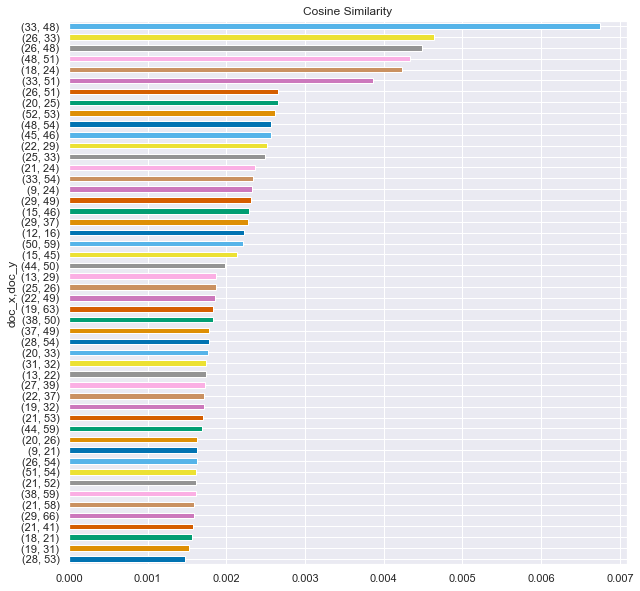

In [42]:
BH_P.cosine.sort_values(ascending=True).tail(50).plot(kind='barh', color=sns.color_palette('colorblind'), figsize=(10,10), title = 'Cosine Similarity')

## Compare Euclidean and Cosine Metrics

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


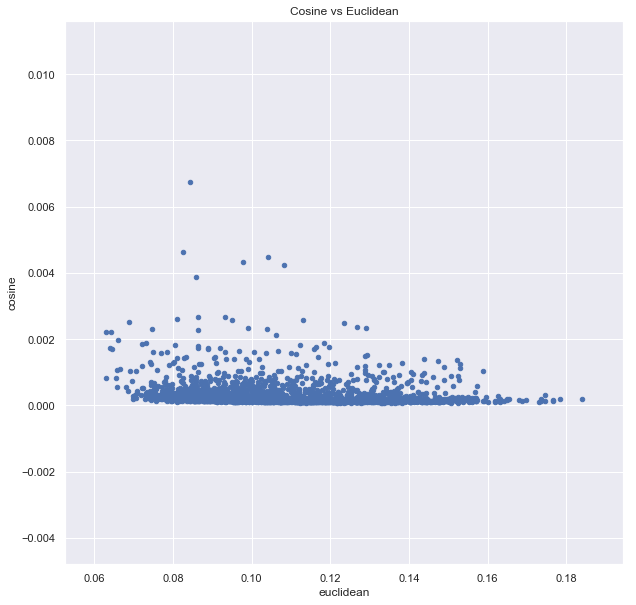

In [43]:
BH_P.plot(kind='scatter', x='euclidean', y='cosine', figsize=(10,10), title='Cosine vs Euclidean')

In [44]:
import matplotlib.pyplot as plt

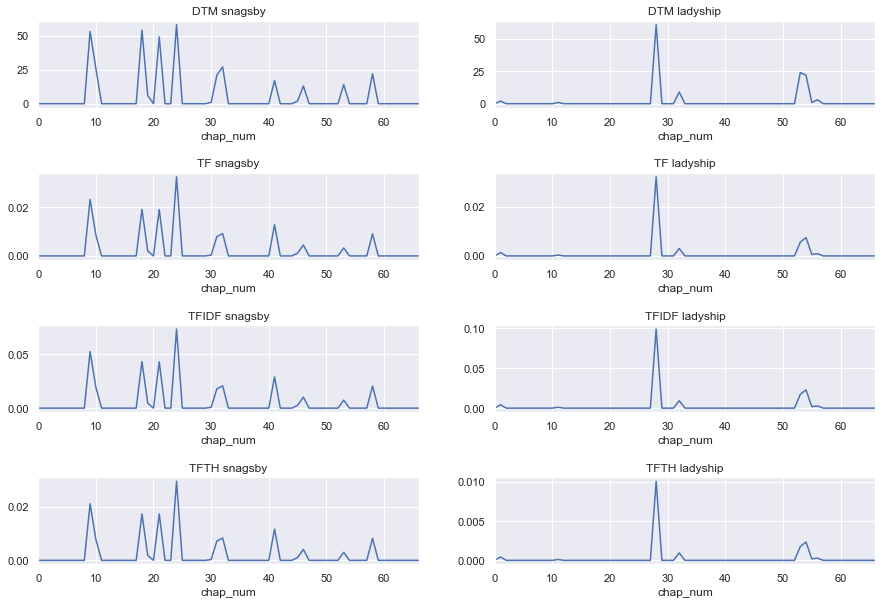

In [46]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('snagsby ladyship'.split()):
    W = get_term_id(BH_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

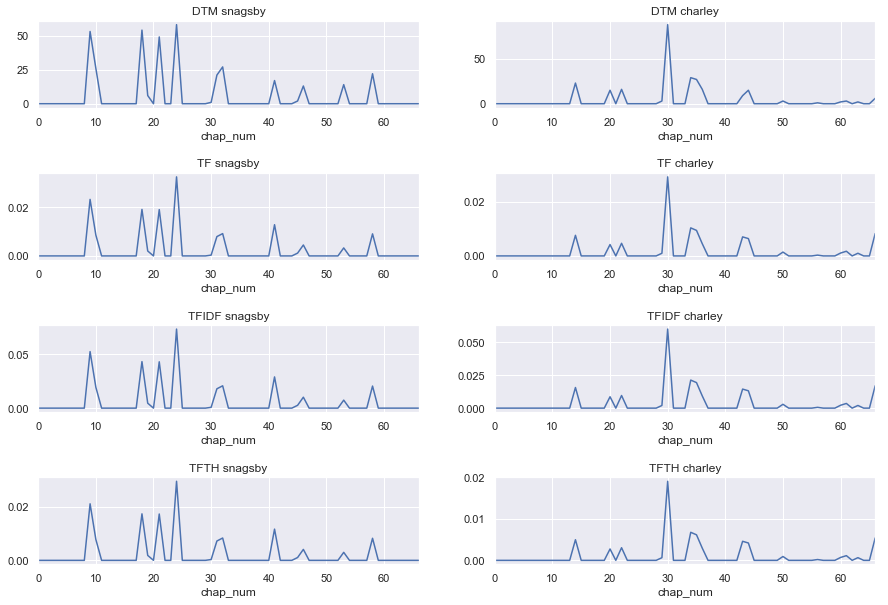

In [47]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('snagsby charley'.split()):
    W = get_term_id(BH_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

In [48]:
BH_V.to_csv('The_Bleak_House_V.csv', index=False)

## Visualize KDE Plots

In [49]:
BH_K.head()

pos token_str  punc  num  term_str  \
chap_num para_num sent_num token_num                                       
0        0        0        0           NN   CHAPTER     0    0   chapter   
                           1          PRP         I     0    0         i   
         1        0        0           IN        In     0    0        in   
                           1          NNP  Chancery     0    0  chancery   
         2        0        0          NNP    London     0    0    london   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             2100  
                           1             6615  
         1        0        0             6781  
                           1             2084  
         2        0        0             7822

In [50]:
lmk = BH_K.copy()

In [51]:
tt = lmk[['term_str','term_id']]
tt.head()

term_str  term_id
chap_num para_num sent_num token_num                   
0        0        0        0           chapter     2100
                           1                 i     6615
         1        0        0                in     6781
                           1          chancery     2084
         2        0        0            london     7822

In [52]:
K = tt.reset_index()

In [53]:
K.rename_axis('offset', inplace=True)

In [54]:
K = K[['term_str','term_id']]
K.head(11).T

offset,0,1,2,3,4,5,6,7,8,9,10
term_str,chapter,i,in,chancery,london,michaelmas,term,lately,over,and,the
term_id,2100,6615,6781,2084,7822,8259,13188,7542,9104,588,13238


In [55]:
vocab_weight = 'tfidf_sum'
vocab_weight_quantile = .94
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 5000
kde_samples = 1000

In [56]:
V1 = BH_V[(BH_V[vocab_weight] > BH_V[vocab_weight].quantile(vocab_weight_quantile)) & (BH_V.n >= vocab_min_n)]

In [57]:
V1.sort_values(vocab_weight, ascending=False).head(10).T

term_id,12126,5746,1082,1762,6083,7633,1855,7279,12076,11099
term_str,snagsby,george,bagnet,bucket,guppy,leicester,caddy,jo,smallweed,richard
n,363,464,235,442,390,466,252,207,245,533
p,0.00100513,0.00128479,0.000650701,0.00122387,0.00107989,0.00129033,0.000697773,0.000573171,0.00067839,0.00147585
port_stem,snagsbi,georg,bagnet,bucket,guppi,leicest,caddi,jo,smallwe,richard
stop,0,0,0,0,0,0,0,0,0,0
df,14,18,5,18,20,28,12,12,10,30
tf_sum,0.152123,0.170978,0.0850032,0.165289,0.154007,0.197393,0.0995565,0.0940383,0.0829498,0.195305
tf_mean,0.0022705,0.00255191,0.0012687,0.002467,0.00229862,0.00294616,0.00148592,0.00140356,0.00123806,0.002915
tf_max,0.0323477,0.0225139,0.0272855,0.0337421,0.0279366,0.0231521,0.021732,0.0273572,0.0167177,0.0210614
tfidf_sum,0.343607,0.324202,0.318266,0.313416,0.268614,0.248465,0.247012,0.233321,0.227628,0.226397


In [58]:
TOP_TERMS = BH_V.sort_values(vocab_weight, ascending=False).term_str.head(30).tolist()

In [59]:
TOP_TERMS

['snagsby',
 'george',
 'bagnet',
 'bucket',
 'guppy',
 'leicester',
 'caddy',
 'jo',
 'smallweed',
 'richard',
 'vholes',
 'guardian',
 'charley',
 'skimpole',
 'ada',
 'jellyby',
 'trooper',
 'tulkinghorn',
 'ladyship',
 'dedlock',
 'volumnia',
 'chadband',
 'says',
 'allan',
 'rouncewell',
 'woodcourt',
 'jarndyce',
 'phil',
 'jobling',
 'mademoiselle']

In [60]:
K = K[K.term_id.isin(V1.index)]

In [61]:
K.head(11).T

offset,3,4,6,11,12,13,15,17,18,21,24
term_str,chancery,london,term,lord,chancellor,sitting,lincoln,inn,hall,weather,mud
term_id,2084,7822,13188,7847,2082,11946,7727,6992,6122,14528,8534


In [62]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()

In [63]:
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [64]:
B.head()

,offset,x
term_str,,
'd,"[21389, 31440, 31469, 45728, 46750, 53861, 561...","[[21389], [31440], [31469], [45728], [46750], ..."
'em,"[9709, 21350, 21762, 22095, 26260, 58215, 8235...","[[9709], [21350], [21762], [22095], [26260], [..."
'll,"[18790, 21042, 21702, 21903, 22858, 22896, 229...","[[18790], [21042], [21702], [21903], [22858], ..."
'm,"[14232, 17925, 18016, 18747, 21936, 36282, 443...","[[14232], [17925], [18016], [18747], [21936], ..."
'prentices,"[53108, 53162, 53396, 53918, 54741, 54781, 107...","[[53108], [53162], [53396], [53918], [54741], ..."


In [65]:
from sklearn.neighbors import KernelDensity as KDE
scale_max = K.index.max()
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

In [66]:
B.head()

,offset,x,kde,scores
term_str,,,,
'd,"[21389, 31440, 31469, 45728, 46750, 53861, 561...","[[21389], [31440], [31469], [45728], [46750], ...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-22.593203345693123, -22.286519902523477, -21..."
'em,"[9709, 21350, 21762, 22095, 26260, 58215, 8235...","[[9709], [21350], [21762], [22095], [26260], [...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-15.582489986397682, -15.444404584356064, -15..."
'll,"[18790, 21042, 21702, 21903, 22858, 22896, 229...","[[18790], [21042], [21702], [21903], [22858], ...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-21.522393525798822, -21.239945561014714, -20..."
'm,"[14232, 17925, 18016, 18747, 21936, 36282, 443...","[[14232], [17925], [18016], [18747], [21936], ...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-17.808808337854543, -17.594444321129856, -17..."
'prentices,"[53108, 53162, 53396, 53918, 54741, 54781, 107...","[[53108], [53162], [53396], [53918], [54741], ...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-67.42960764538506, -66.66186863815933, -65.8..."


In [67]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

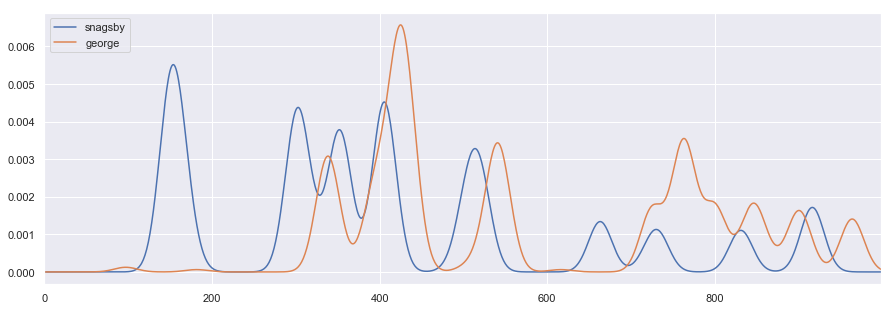

In [68]:
FIG = dict(figsize=(15, 5))
PLOTS.loc['snagsby'].plot(**FIG)
PLOTS.loc['george'].plot(**FIG)
plt.legend(loc='upper left') 

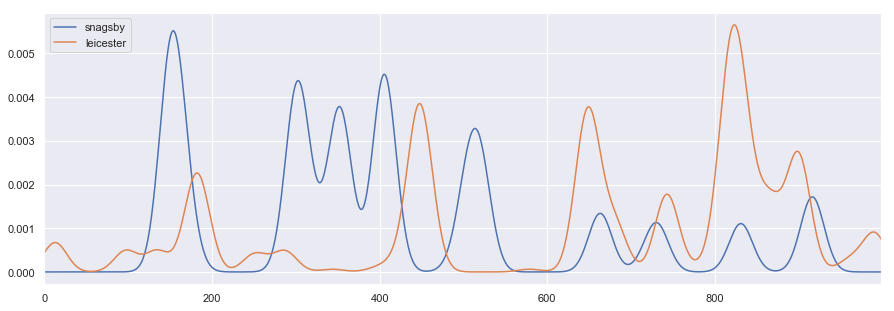

In [70]:
PLOTS.loc['snagsby'].plot(**FIG)
PLOTS.loc['leicester'].plot(**FIG)
plt.legend(loc='upper left') 

## Compute TFIDF

In [71]:
WORDS = (BH_K.punc == 0) & (BH_K.num == 0) & BH_K.term_id.isin(BH_V[BH_V.stop==0].index)

In [72]:
BOW = BH_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [73]:
DTM = BOW.unstack().fillna(0)

In [74]:
alpha = .000001 
alpha_sum = alpha * BH_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [75]:
N_docs = DTM.shape[0]
BH_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / BH_V[BH_V.stop==0]['df'])

In [76]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,14993,14994,14995,14996,14997,14998,14999,15000,15001,15002
chap_num,,,,,,,,,,,,,,,,,,,,,
0,4.424525e-09,4.424525e-09,3.268474e-09,4.424525e-09,4.424525e-09,4.424525e-09,4.424525e-09,4.424525e-09,4.424525e-09,4.424525e-09,...,4.424525e-09,4.424525e-09,4.424525e-09,4.424525e-09,2.539087e-09,4.424525e-09,4.424525e-09,4.424525e-09,3.695138e-09,4.424525e-09
1,4.215446e-09,4.215446e-09,3.114024e-09,4.215446e-09,4.215446e-09,4.215446e-09,4.215446e-09,4.215446e-09,4.215446e-09,4.215446e-09,...,4.215446e-09,4.215446e-09,4.215446e-09,4.215446e-09,2.419104e-09,4.215446e-09,4.215446e-09,4.215446e-09,3.520526e-09,4.215446e-09
2,1.657848e-09,1.657848e-09,1.224681e-09,1.657848e-09,1.657848e-09,1.657848e-09,1.657848e-09,1.657848e-09,1.657848e-09,1.657848e-09,...,1.657848e-09,1.657848e-09,1.657848e-09,1.657848e-09,9.513836e-10,1.657848e-09,1.657848e-09,1.657848e-09,1.384550e-09,1.657848e-09
3,2.533856e-09,2.533856e-09,1.871806e-03,2.533856e-09,2.533856e-09,2.533856e-09,2.533856e-09,2.533856e-09,2.533856e-09,2.533856e-09,...,2.533856e-09,2.533856e-09,2.533856e-09,2.533856e-09,1.454096e-09,2.533856e-09,2.533856e-09,2.533856e-09,2.116148e-09,2.533856e-09
4,2.153375e-09,2.153375e-09,1.590736e-09,2.153375e-09,2.153375e-09,2.153375e-09,2.153375e-09,2.153375e-09,2.153375e-09,2.153375e-09,...,2.153375e-09,2.153375e-09,2.153375e-09,2.153375e-09,1.235750e-09,2.153375e-09,2.153375e-09,2.153375e-09,1.798389e-09,2.153375e-09


## Principal Component Analysis

In [77]:
def get_pca(df, k=2):
    from sklearn.decomposition import PCA
    pca = PCA(k)
    X = pd.DataFrame(pca.fit_transform(df))
    X.index = df.index.tolist()
    return X

In [78]:
pca1 = get_pca(TFIDF, k=2)
pca1

,0,1
0,-0.008413,-0.007172
1,-0.005779,-0.003731
2,-0.006220,-0.007698
3,-0.010008,-0.013500
4,-0.007658,-0.008293
5,-0.008140,-0.011356
6,-0.004407,-0.005531
7,-0.006229,-0.007251
8,-0.006703,-0.007931
9,-0.013614,0.040309


In [79]:
X = np.array(pca1)
X

array([[-8.41336237e-03, -7.17205672e-03],
       [-5.77887442e-03, -3.73050693e-03],
       [-6.22008386e-03, -7.69785996e-03],
       [-1.00084327e-02, -1.35002791e-02],
       [-7.65824494e-03, -8.29255562e-03],
       [-8.13963796e-03, -1.13564709e-02],
       [-4.40726720e-03, -5.53143840e-03],
       [-6.22943000e-03, -7.25073119e-03],
       [-6.70349506e-03, -7.93120697e-03],
       [-1.36141798e-02,  4.03093675e-02],
       [-8.82579346e-03,  1.56559162e-02],
       [-4.58219834e-03, -4.36369539e-03],
       [-8.81435123e-03, -1.35188517e-02],
       [-1.03986205e-02, -1.55886042e-02],
       [-7.13035092e-03, -8.99506022e-03],
       [-1.05681860e-02,  2.27316030e-02],
       [-8.93693670e-03, -1.39680873e-02],
       [-6.84365120e-03, -8.57941737e-03],
       [-1.93538697e-02,  6.86468676e-02],
       [-3.07704475e-03,  3.16087655e-03],
       [ 2.43770484e-02, -4.99914923e-04],
       [-8.13407808e-03,  3.94379570e-02],
       [-1.25205412e-02, -1.87015036e-02],
       [ 3.

In [80]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [81]:
print(pca.components_)

[[1. 0.]
 [0. 1.]]


In [82]:
print(pca.explained_variance_)

[0.00053986 0.00042387]


In [83]:
print(pca.mean_)

[-2.77037928e-18 -1.34635255e-18]


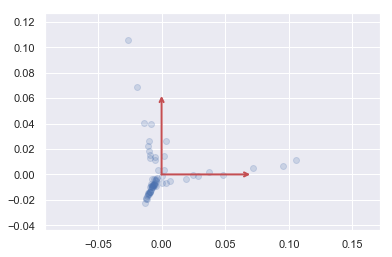

In [84]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='r')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

## Sentiment Analysis

In [85]:
import sqlite3

In [86]:
# Developed in other notebook
lex_db = 'lexicon/lexicons.db'

In [88]:
text_db = 'db/Bleak_house.db'
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

emo = 'bing_sentiment'
#emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

In [89]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

In [90]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [91]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-1.0
abate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
abdicate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [92]:
emo_cols = combo.columns

In [93]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'gi_sentiment'],
      dtype='object')

In [94]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE punc = 0", db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

In [95]:
tokens = tokens.join(combo, on='term_str', how='left')

In [96]:
tokens[emo].sample(10)

chap_num  para_num  sent_num  token_num
49        64        0         3           NaN
2         61        1         15          NaN
45        35        1         4           NaN
15        73        3         4           NaN
19        122       1         26          NaN
          86        0         11          NaN
32        2         5         10          NaN
33        69        3         21          NaN
7         111       3         11          NaN
27        10        2         4           NaN
Name: bing_sentiment, dtype: float64

In [97]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [98]:
tokens.head(10)

pos   token_str  punc  num    term_str  \
chap_num para_num sent_num token_num                                           
0        0        0        0           NN     CHAPTER     0    0     chapter   
                           1          PRP           I     0    0           i   
         1        0        0           IN          In     0    0          in   
                           1          NNP    Chancery     0    0    chancery   
         2        0        0          NNP      London     0    0      london   
                  1        0          NNP  Michaelmas     0    0  michaelmas   
                           1           NN        term     0    0        term   
                           2           RB      lately     0    0      lately   
                           3           IN        over     0    0        over   
                           5           CC         and     0    0         and   

                                      term_id  nrc_anger  nrc_anticipation  \
chap_num para_num sent_num token_num                                         
0        0        0        0             1993        0.0               0.0   
                           1             6518        0.0               0.0   
         1        0        0             6683        0.0               0.0   
                           1             1977        0.0               0.0   
         2        0        0             7728        0.0               0.0   
                  1        0             8164        0.0               0.0   
                           1            13100        0.0               0.0   
                           2             7446        0.0               0.0   
                           3             9013        0.0               0.0   
                           5              480        0.0               0.0   

                                      nrc_disgust  nrc_fear  nrc_joy  \
chap_num para_num sent_num token_num                                   
0        0        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
         1        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
         2        0        0                  0.0       0.0      0.0   
                  1        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
                           2                  0.0       0.0      0.0   
                           3                  0.0       0.0      0.0   
                           5                  0.0       0.0      0.0   

                                      nrc_negative  nrc_positive  nrc_sadness  \
chap_num para_num sent_num token_num                                            
0        0        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
         1        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
         2        0        0                   0.0           0.0          0.0   
                  1        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
                           2                   0.0           0.0          0.0   
                           3                   0.0           0.0          0.0   
                           5                   0.0           0.0          0.0   

                                      nrc_surprise  nrc_trust  bing_negative  \
chap_num para_num sent_num token_num                                           
0        0        0        0                   0.0        0.0            0.0   
                           1                   0.0        0.0 

In [99]:
FIG = dict(figsize=(20, 5), legend=True, fontsize=14, rot=45)

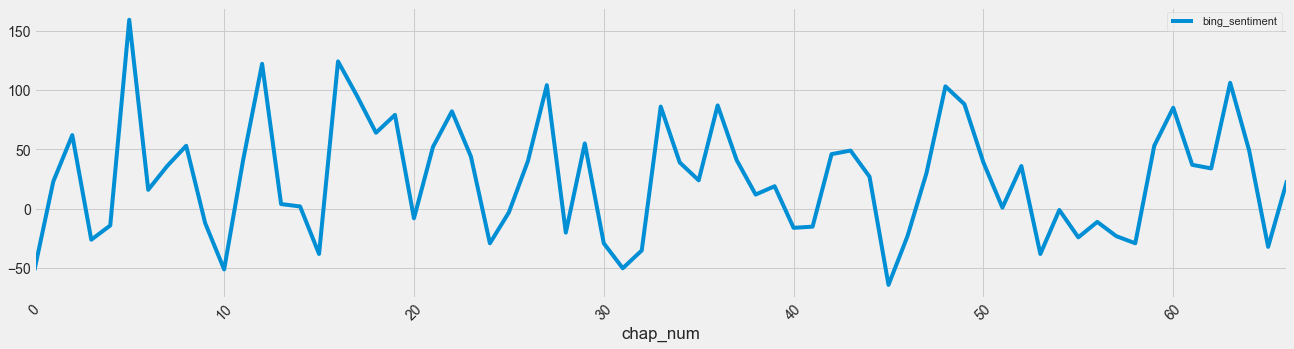

In [100]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

In [101]:
by_chaps= tokens.groupby(CHAPS)[emo_cols].sum()

In [102]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [103]:
tokens['html'].head()

chap_num  para_num  sent_num  token_num
0         0         0         0             <span class='sent0'>CHAPTER</span>
                              1                   <span class='sent0'>I</span>
          1         0         0                  <span class='sent0'>In</span>
                              1            <span class='sent0'>Chancery</span>
          2         0         0              <span class='sent0'>London</span>
Name: html, dtype: object

In [104]:
by_chaps['chaps_str'] = tokens.groupby(CHAPS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_chaps['html_str'] = tokens.groupby(CHAPS).html.apply(lambda x: x.str.cat(sep=' '))

In [105]:
by_chaps[['chaps_str', 'html_str']].head()

,chaps_str,html_str
chap_num,,
0,chapter i in chancery london michaelmas term l...,<span class='sent0'>CHAPTER</span> <span class...
1,chapter ii in fashion it is but a glimpse of t...,<span class='sent0'>CHAPTER</span> <span class...
2,chapter iii a progress i have a great deal of ...,<span class='sent0'>CHAPTER</span> <span class...
3,chapter iv telescopic philanthropy we were to ...,<span class='sent0'>CHAPTER</span> <span class...
4,chapter v a morning adventure although the mor...,<span class='sent0'>CHAPTER</span> <span class...


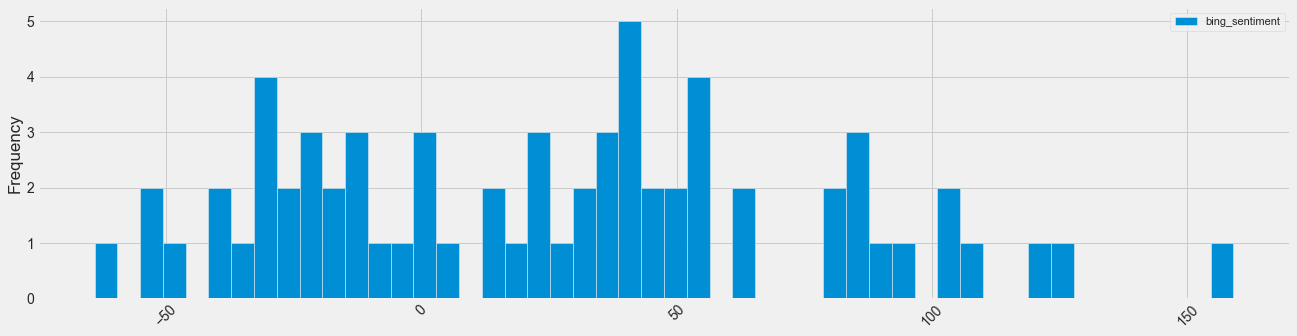

In [106]:
by_chaps[emo].plot.hist(**FIG, bins=50)

### Positive

In [107]:
by_chaps.sort_values(emo, ascending=False)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
5,159.0,chapter vi quite at home the day had brightene...
16,124.0,chapter xvii esther s narrative richard very o...
12,122.0,chapter xiii esther s narrative we held many c...
63,106.0,chapter lxiv esther s narrative soon after i h...
27,104.0,chapter xxviii the ironmaster sir leicester de...
48,103.0,chapter xlix dutiful friendship a great annual...
17,95.0,chapter xviii lady dedlock it was not so easy ...
49,88.0,chapter l esther s narrative it happened that ...
36,87.0,chapter xxxvii jarndyce and jarndyce if the se...


### Negative

In [108]:
by_chaps.sort_values(emo, ascending=True)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
45,-64.0,chapter xlvi stop him darkness rests upon tom ...
0,-52.0,chapter i in chancery london michaelmas term l...
10,-51.0,chapter xi our dear brother a touch on the law...
31,-50.0,chapter xxxii the appointed time it is night i...
15,-38.0,chapter xvi tom all alone s my lady dedlock is...
53,-38.0,chapter liv springing a mine refreshed by slee...
32,-35.0,chapter xxxiii interlopers now do those two ge...
65,-32.0,chapter lxvi down in lincolnshire there is a h...
24,-29.0,chapter xxv mrs snagsby sees it all there is d...


### Multinomial Emotions

In [109]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [110]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


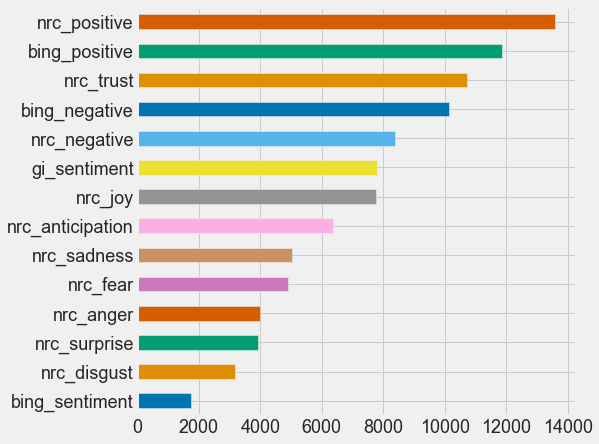

In [111]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18, color=sns.color_palette('colorblind'))

### Visualize KDE for Emotions

In [112]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [113]:
B.head()

,x
emo,
nrc_anger,"[[96], [124], [127], [235], [295], [320], [338..."
nrc_anticipation,"[[96], [99], [357], [366], [456], [486], [526]..."
nrc_disgust,"[[11], [79], [96], [103], [124], [214], [235],..."
nrc_fear,"[[96], [122], [124], [150], [155], [295], [320..."
nrc_joy,"[[47], [99], [189], [357], [526], [576], [594]..."


In [114]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

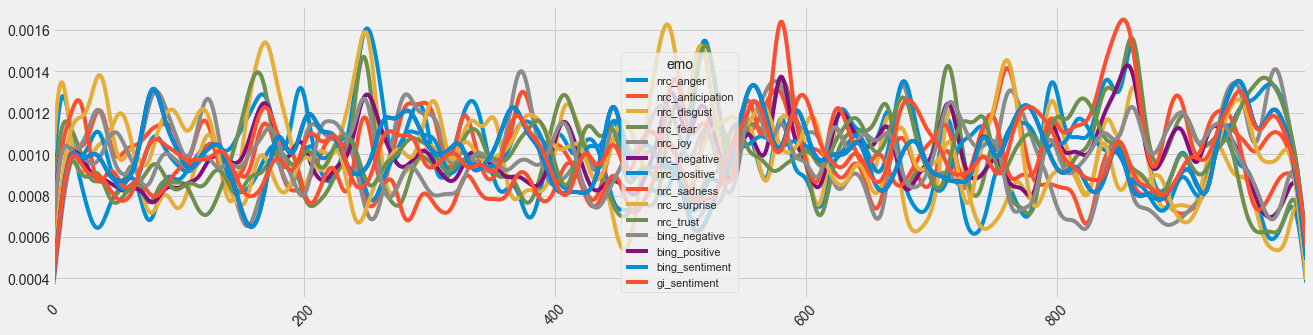

In [115]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T
PLOTS.plot(**FIG)

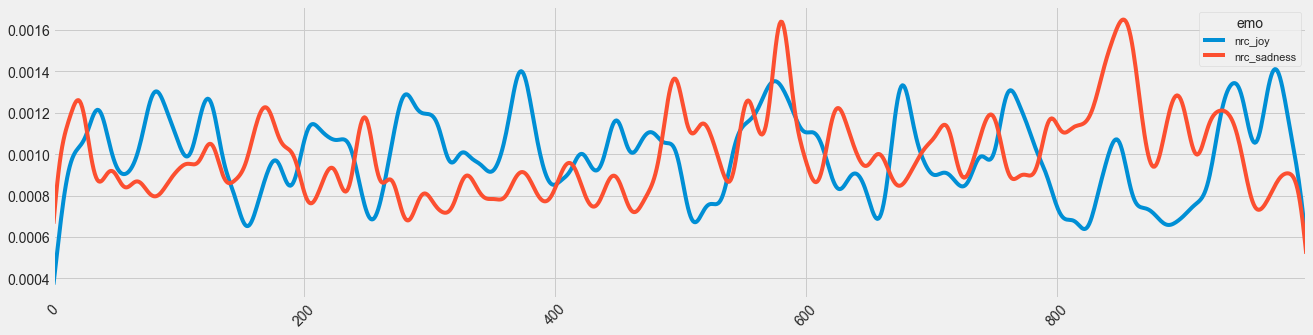

In [116]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

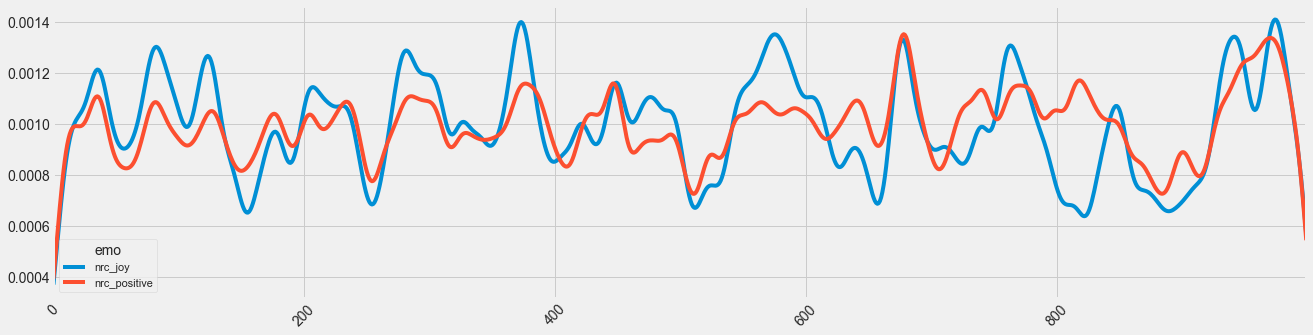

In [117]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)

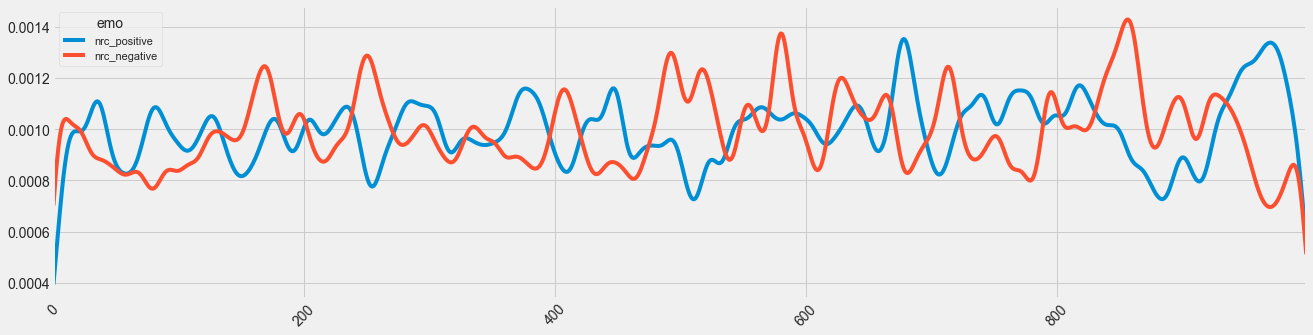

In [118]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)

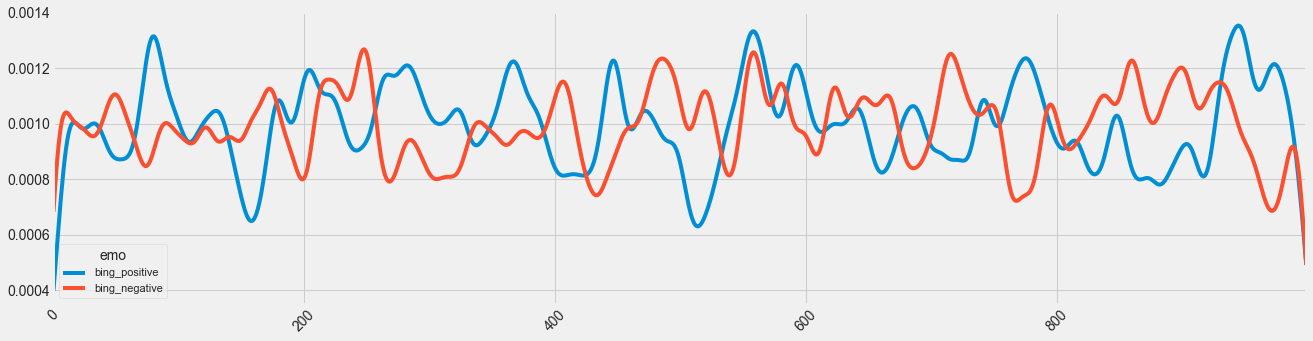

In [119]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)